#### 맹장 예상 부위 CT이미지 입력 학습모델
좌측 이미지 크롭

In [1]:
#패키지
import SimpleITK as sitk
import pydicom as dcm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
import os
import random

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2292382584248854302
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11990532096
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4041107983099832971
physical_device_desc: "device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11990532096
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
i

In [3]:
print(os.getcwd())
print(os.listdir("./dataset/Dicom"))

/home/ubuntu/scshin88
['충수염', '정상']


In [4]:
NORMAL_LIMIT_CNT = 150
ABNORMAL_LIMIT_CNT = 100

In [5]:
normal_path = 'dataset/Dicom/정상'
abnormal_path = 'dataset/Dicom/충수염'
normal_dicom_paths = [
    os.path.join(os.getcwd(), normal_path, x)
    for x in os.listdir(normal_path)
]
abnormal_dicom_paths = [
    os.path.join(os.getcwd(), abnormal_path, x)
    for x in os.listdir(abnormal_path)
]

normal_dicom_paths = normal_dicom_paths[:NORMAL_LIMIT_CNT]
abnormal_dicom_paths = abnormal_dicom_paths[:ABNORMAL_LIMIT_CNT]

print("정상 Dicom: " + str(len(normal_dicom_paths)))
print("충수염 Dicom: " + str(len(abnormal_dicom_paths)))

정상 Dicom: 150
충수염 Dicom: 100


In [21]:
def read_dicom_file(filepath):
    """Read and load volume"""
    
    dicom_path = filepath
    series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicom_path)
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicom_path, series_ids[0])
    series_reader = sitk.ImageSeriesReader()
    series_reader.SetFileNames(series_file_names)
    dicom_sitk = series_reader.Execute()
    
    dicom_images = sitk.GetArrayFromImage(dicom_sitk)
    dicom_images = dicom_images.transpose(1,2,0)
    return dicom_images

def normalize(volume, min = -500, max = 700):
    """Normalize the volume"""
    
    
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1],:]
    
    return croped_image

def crop_left(img):
    """이미지 좌측 Crop"""
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    left_max_height = int(current_height / 2)
    min_depth = int(current_depth / 2)
    img = img[:,:left_max_height,:min_depth]
    return img

def resize_volume(img,desired_width=128,desired_height=128,desired_depth=64):
    """Dicom 이미지 재구성(Resample)
        512,512, depth > (default) 128,128,64
    """
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth 
    width_factor = 1 / width 
    height_factor = 1 / height
    # Rotate
    #img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    images = read_dicom_file(path)
    #print(images.shape)
    
    #전처리 로직 추가 필요
    
    images = crop_left(images) # 좌측 이미지만 사용
    images = crop_image(images) #불필요한 이미지 부분 삭제
    #print(images.shape)
    # Normalize
    images = normalize(images)
    # Resize width, height and depth
    #if images.shape[-1] >= 300:
    #    print('이미지 확인 필요_'+path)
    images = resize_volume(images,128,64,128)
    #print(images.shape)

    #images = crop_left(images)
    #print(images.shape)
    return images

In [7]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def preprocessing_no_roatate(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [22]:
#Read Dicom
abnormal_dicom = np.array([process_scan(path) for path in abnormal_dicom_paths])
normal_dicom = np.array([process_scan(path) for path in normal_dicom_paths])
print('abnormal_dicom shape:',abnormal_dicom.shape)
print('normal_dicom shape:',normal_dicom.shape)

#충수염 1, 정상 0 라벨링
abnormal_labels = np.array([1 for _ in range(len(abnormal_dicom))])
normal_labels = np.array([0 for _ in range(len(normal_dicom))])
print('abnormal_labels shape:',abnormal_labels.shape)
print('normal_dicom shape:',normal_labels.shape)

X = np.concatenate((abnormal_dicom, normal_dicom), axis=0)
Y = np.concatenate((abnormal_labels, normal_labels), axis=0)
print('X : ',X.shape)
print('Y : ',Y.shape)

abnormal_dicom shape: (100, 128, 64, 128)
normal_dicom shape: (150, 128, 64, 128)
abnormal_labels shape: (100,)
normal_dicom shape: (150,)
X :  (250, 128, 64, 128)
Y :  (250,)


In [23]:
#데이터셋 분할
from sklearn.model_selection import train_test_split
# train:validation:test = 6:2:2
X_train, X_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.4, shuffle=True, random_state=1004)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, random_state=1004)

X_val_test,y_val_test = None,None

print('X_train : ',X_train.shape,'X_val : ',X_val.shape,'X_test : ',X_test.shape)
print('y_train : ',y_train.shape,'y_val : ',y_val.shape,'y_test : ',y_test.shape)

X_train :  (150, 128, 64, 128) X_val :  (50, 128, 64, 128) X_test :  (50, 128, 64, 128)
y_train :  (150,) y_val :  (50,) y_test :  (50,)


In [24]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_val))
    .map(preprocessing_no_roatate)
    .batch(batch_size)
    .prefetch(2)
)

test_dataset = (
    test_loader.shuffle(len(X_test))
    .map(preprocessing_no_roatate)
    .batch(batch_size)
    .prefetch(2)
)

[0]
Dimension of the CT scan is: (128, 64, 128, 1)


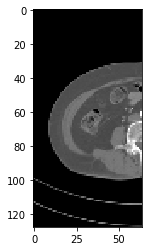

In [31]:
#샘플 데이터 확인
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print(labels.numpy())
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 120]), cmap="gray")
plt.show()

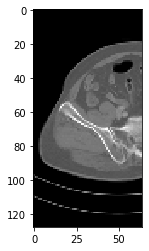

In [47]:
plt.imshow(X_train[2,:, :, 80], cmap="gray")
plt.show()

In [36]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

print(X_train.shape)

# Build model.
model = get_model(width=X_train.shape[1], height=X_train.shape[2], depth=X_train.shape[3])
model.summary()

(150, 128, 64, 128)
Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 64, 128, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 62, 126, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 31, 63, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 31, 63, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 29, 61, 64)    110656    
                                         

In [49]:
# Compile model.
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

from datetime import datetime

model_dir = './model_weight/'

model_filename = 'case2_model_3dcnn_'+datetime.now().strftime('%Y%m%d%H%M%S')+'.h5'


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir,model_filename), save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=100)

# Train the model, doing validation at the end of each epoch
epochs = 1000

print('Fitting Start')

#model.load_weights("case1_model_3dcnn_20220824172854.h5") #기존 학습 가중치 로드

hist = model.fit(
    train_dataset,
    validation_data=train_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Fitting Start
Epoch 1/1000
150/150 - 11s - loss: 0.6825 - accuracy: 0.5733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.4267 - val_loss: 0.6568 - val_accuracy: 0.6600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5160 - val_prc: 0.3380 - 11s/epoch - 74ms/step
Epoch 2/1000
150/150 - 9s - loss: 0.6825 - accuracy: 0.5733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.4267 - val_loss: 0.6570 - val_accuracy: 0.6600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4733 - val_prc: 0.3067 - 9s/epoch - 59ms/step
Epoch 3/1000
150/150 - 9s - loss: 0.6825 - accuracy: 0.5733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.4267 - val_loss: 0.6571 - val_accuracy: 0.6600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5107 - val_prc: 0.3272 - 9s/epoch - 59ms/step
Epoch 4/1000
150/150 - 9s - loss: 0.6826 - accuracy: 0.5733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - pr

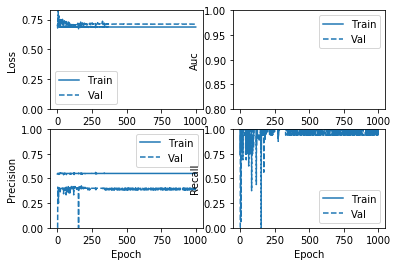

In [42]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(hist)

In [54]:
# Load best weights.
#model.load_weights("3d_image_classification.h5")
print(y_test[3])
prediction = model.predict(np.expand_dims(X_test[2], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

0
This model is 45.75 percent confident that CT scan is normal
This model is 54.25 percent confident that CT scan is abnormal


In [55]:
results = model.evaluate(test_dataset, batch_size=128,verbose=1)

40/40 [==============================] - 1s 21ms/step - loss: 0.7158 - tp: 16.0000 - fp: 21.0000 - tn: 1.0000 - fn: 2.0000 - accuracy: 0.4250 - precision: 0.4324 - recall: 0.8889 - auc: 0.2702 - prc: 0.3237            
